# DPAP Clustering - USR

using 10k frames from the DPAP-ACN trajectory

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
import sys
from sklearn import datasets, metrics, cluster

from IPython import display
%matplotlib inline

In [2]:
sys.path.append("../src")
import mdutils
import myclusters2
import mymetrics2
import pyusr

## Load data and set envs

In [3]:
data_dir = "/media/gmancini/09e994f6-73c1-425f-b9e7-19fb6b78e81d/perDaniele/dpap_acn/"
os.chdir(data_dir)
!ls

200frames	     energy.agr.gz	index.ndx	 rmsd_dpap_acn_50ps.dat
autocorr.xvg	     energy.xvg		nojump_50ps.xtc  rmsd_hex.dat.bz2
center_50ps.xtc      ener.part0002.edr	nshell.xvg	 rmsd.xvg
confout.gro	     ener_part1.edr	order.xtc	 testD1.tpr
dpap_fit_50ps.xtc    fixed.edr		rdf.dat		 traj.xtc
dpap_nofit_50ps.xtc  fshell.pdb		rdf.xvg		 usrmat_dpap_50ps.dat
dpap.pdb	     fshell.xtc		rmsd.dat.bz2	 xxx


In [4]:
data = np.loadtxt("xxx")

In [5]:
data.shape

(10001, 10001)

## Test1: PAM

In [8]:
K = [k for k in range(2,20)]
nfeatures = 36
niter = 3000
restart = 15
conv = 1e-6
centroid = list()

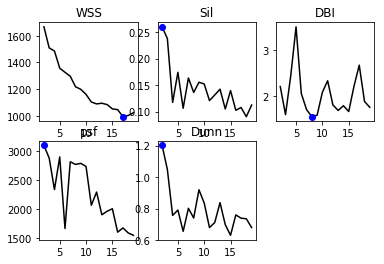

In [9]:
sil = list()
DBI = list()
psf = list()
Dunn= list()
WSS = list()

for k in K:
    my_estimator = myclusters2.PAM(D=data,X=None,K=k,\
                                   niter=niter,nrun=restart,boot='random',conv=conv,metric='precomputed')
    my_estimator.do_clustering()
    myclusters = my_estimator.clusters
    centroid.append(set(myclusters))
    WSS.append(my_estimator.inertia)
    
    myeval = mymetrics2.cluster_eval(metric='precomputed',clusters=myclusters,D=data)
    DBI.append(myeval(noise="ignore",method="DBI"))
    Dunn.append(myeval(noise="ignore",method="Dunn",inter="allav",intra="allav"))
    psf.append(myeval(noise="ignore",method="psF",centroid=True)[0])
    sil.append(metrics.silhouette_score(data,myclusters,metric='precomputed'))   

plt.figure()    

plt.subplot(231)
WSS = np.asarray(WSS); vmax = np.min(WSS); kmax = np.argmin(WSS)+2
plt.plot(K,WSS,'k',kmax, vmax, 'bo')
plt.title('WSS')

plt.subplot(232)
sil = np.asarray(sil); vmax = np.max(sil); kmax = np.argmax(sil)+2
plt.plot(K,sil,'k',kmax, vmax, 'bo')
plt.title('Sil')

plt.subplot(233)
DBI = np.asarray(DBI); vmax = np.min(DBI); kmax = np.argmin(DBI)+2
plt.plot(K,DBI,'k',kmax, vmax, 'bo')
plt.title('DBI')

plt.subplot(234)
psf = np.asarray(psf); vmax = np.max(psf); kmax = np.argmax(psf)+2
plt.plot(K,psf,'k',kmax, vmax, 'bo')
plt.title('psf')

plt.subplot(235)
Dunn = np.asarray(Dunn); vmax = np.max(Dunn); kmax = np.argmax(Dunn)+2
plt.plot(K,Dunn,'k',kmax, vmax, 'bo')
plt.title('Dunn')

plt.show()

In [11]:
print("centroids",set(centroid[1]))

centroids {4754, 5099, 1790}


## Density Peaks

In [12]:
spacedef="precomputed"
usenoise="ignore"
percent = np.array((0.5,1.,1.5,2.,2.5,3.))
#percent = np.array((1.,1.5,1.75))
ndata = data.shape[0]


############################

Determining cutoff using a % of neighbors= 0.5
Cutoff 0.0551151


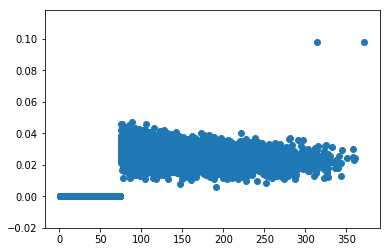


############################

Determining cutoff using a % of neighbors= 1.0
Cutoff 0.0643842


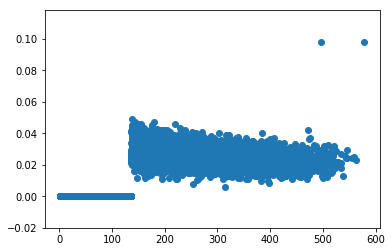


############################

Determining cutoff using a % of neighbors= 1.5
Cutoff 0.0708207


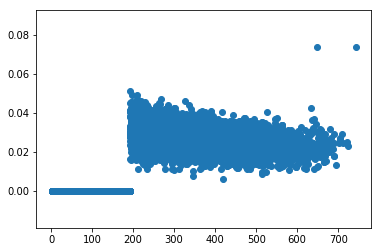


############################

Determining cutoff using a % of neighbors= 2.0
Cutoff 0.0759716


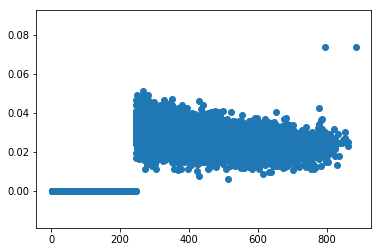


############################

Determining cutoff using a % of neighbors= 2.5
Cutoff 0.0803669


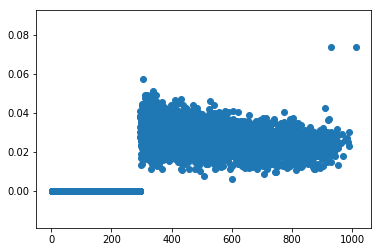


############################

Determining cutoff using a % of neighbors= 3.0
Cutoff 0.0842409


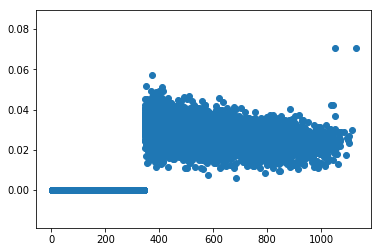

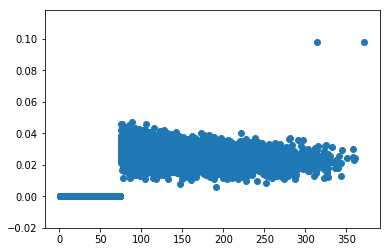

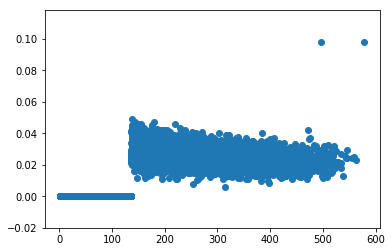

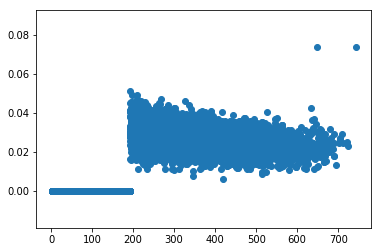

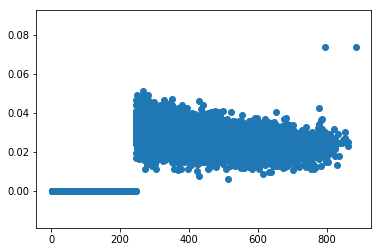

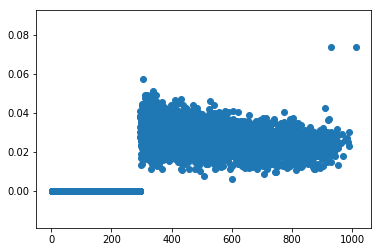

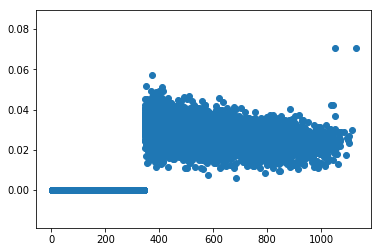

In [13]:
for p in percent:
    fig = plt.figure()
    print("\n############################\n")
    ###############
    estimator = myclusters2.density_peaks(cutoff="auto",percent=p,metric="precomputed",\
                                     kernel="gaussian",D=data)
    print("Cutoff",estimator.cutoff)
    rho,delta = estimator.decision_graph()
    plt.scatter(rho,delta)
    display.display(fig)

In [26]:
RMIN = 250
DELTA = 0.06
p = 0.5

In [27]:
estimator = myclusters2.density_peaks(cutoff="auto",percent=p,metric="precomputed",\
                                 kernel="gaussian",D=data)
print("Cutoff",estimator.cutoff)
rho,delta = estimator.decision_graph()
centroids,points = estimator.get_centroids(rmin=RMIN,dmin=DELTA)
clusters = estimator.assign_points()

robust_clusters = estimator.create_halo()
halo = 0
for c in centroids:
    N = len(robust_clusters[robust_clusters==c])
    H = len(clusters[clusters==c]) - N
    halo = halo + H
    print("%d elements and %d HALO points found in cluster %d" % (N,H,c))        
norm = (ndata-halo)/ndata

Determining cutoff using a % of neighbors= 0.5
Cutoff 0.0551151
84 elements and 2927 HALO points found in cluster 5298
2 elements and 6988 HALO points found in cluster 9200
